# Phase-Only Compressive Sensing

This notebook aims at testing the possibility to recovery a signal from phase-only observations, as described in the papers:

* [1] L. Jacques, T. Feuillen, "The importance of phase in complex compressive sensing", 2020 ([arXiv](https://arxiv.org/abs/2001.02529))
* [2] L. Jacques, T. Feuillen, "Keep the phase! Signal recovery in phase-only compressive sensing", 2020 ([arXiv](https://arxiv.org/abs/2011.06499))

The code relies on the "basis pursuit denoising" (BPDN) solver implemented by ["SPGL1: A solver for sparse least squares"](https://friedlander.io/spgl1/), and in particular its [port to Python](https://github.com/drrelyea/spgl1).

As described in [1,2], the phase-only compressive sensing is defined from the following model:

$$
\boldsymbol z = {\rm sign}_{\mathbb C}(\boldsymbol \Phi \boldsymbol x)
\tag{PO-CS}
$$

with ${\rm sign}_{\mathbb C}(\lambda) = \lambda/|\lambda|$ the complex sign operator, a complex Gaussian random matrix $\boldsymbol \Phi \sim \mathbb C \mathcal N^{m \times n}(0,2)$, and $\boldsymbol x$ an $k$-sparse vector in $\mathbb R^n$.

The papers above develop a method to recover, up to a global amplitude, $\boldsymbol x$ from $\boldsymbol z$.

**Remark:** All the codes below are based on a complex Gaussian matrix $\boldsymbol \Phi$. However, complex Bernoulli and random partial Fourier sensing are also implemented through the function ``generate_sensing_mtx(m,n,model='gaussian')``, with ``model`` in ``{'gaussian','bernouilli','fourier'}``. Feel free to play with them.

**Requirements**:
* Numpy, SciPy, MatplotLib
* [SPGL1](https://github.com/drrelyea/spgl1)
* [tqdm](https://github.com/tqdm/tqdm) (just for progress bars ;-)

**Preliminaries**: Loading important modules. If you cannot run or install the progress bar of ```tqdm```, just comment the lines where it's used. See below.

In [1]:
import numpy as np
from scipy import interpolate
from scipy.sparse.linalg import LinearOperator

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

#from scipy.sparse.linalg import LinearOperator
#from scipy.sparse import spdiags
import spgl1

# for nice progress bars (comment it if it doesn't work)
from tqdm.notebook import tqdm


# Initialize random number generators
np.random.seed(43273289)
%matplotlib inline

## 1. Noiseless PO-CS reconstruction

Let us define a few important functions, namely the complex sign operator ${\rm sign}_{\mathbb C}$, the constant $\kappa = \sqrt{\pi/2}$, the signal-to-noise ratio metric, as well as a shortcut to call the BPDN solver from SPGL1.

In [2]:
# numerical error constant: 10*np.finfo(np.float32).eps
epsilon = 10*np.finfo(np.float32).eps 

# complex sign operator
signc = lambda x: x / (np.absolute(x) + (x == 0)*epsilon) 

# the kappa constant (see [1])
kappa = np.sqrt(np.pi/2)

# the SNR metric between two signals (in dB)
snr = lambda a,b: 20*np.log10(np.linalg.norm(a)/np.linalg.norm(a-b)) 

# simplifying the call to BP from SPGL1 and storing parameters in the same time
#bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=1e-7, bp_tol=1e-7)[0]
#bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=1e-8, bp_tol=1e-8, iscomplex=False)[0]
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=1e-7, bp_tol=1e-7)[0]

# simplifying the call to BPDN from SPGL1 and storing parameters in the same time
bpdnalg = lambda A, b, sigma: spgl1.spg_bpdn(A, b, sigma)[0]

# a function to generate the j^th canonical vector in d dimensions
def generate_canonic_vec(d,j):
    e_j = np.zeros(d)
    e_j[j] = 1.0
    return e_j

A function to generate real $k$-sparse signals in $\mathbb R^n$.

In [3]:
def generate_sparse_sig(k,n):
    idx = np.random.permutation(n)
    x = np.zeros(n)
    x[idx[0:k]] = np.random.randn(k)
    return x

Let's define several functions generating $m \times n$ random sensing matrix constructions, namely complex Gaussian, complex Bernoulli, and partial Fourier random matrices.

In [4]:
def generate_complex_Gaussian_mtx(m,n):
    Phi = np.random.randn(m, n) + np.random.randn(m, n) *1j;
    A = Phi/np.sqrt(m)
    return A

def generate_complex_Bernoulli_mtx(m,n):
    Phi = np.sign(np.random.randn(m, n)) + np.sign(np.random.randn(m, n)) *1j;
    A = Phi/np.sqrt(m)
    return A

class generate_partial_Fourier_mtx(LinearOperator):
    def __init__(self, m, n):
        self.m = m
        self.n = n
        self.shape = (m, n)
        self.dtype = np.complex128
        self.idx = np.random.permutation(n)[0:m]
        
    def _matvec(self, x):
        z = np.fft.fft(x) / np.sqrt(self.m) 
        return z[self.idx]
    
    def _rmatvec(self, y):
        z = np.zeros(self.n, dtype=complex)
        z[self.idx] = y
        return np.fft.ifft(z) * self.n / np.sqrt(self.m)

def generate_sensing_mtx(m,n,model='gaussian'):
    if model == 'gaussian':
        return generate_complex_Gaussian_mtx(m,n)
    elif model == 'bernoulli':
        return generate_complex_Bernoulli_mtx(m,n)
    elif model == 'fourier':
        return generate_partial_Fourier_mtx(m,n)
    else:
        print("unknown model")
        

A function to turn complex linear operators (applied to real vectors) into real linear operators with two times as many rows.

In [5]:
class Op2Real(LinearOperator):
    def __init__(self, A):
        self.A = A
        m, n = A.shape
        self.shape = [2*m, n]
        self.dtype = np.float64
        
    def _matvec(self, x):
        return np.concatenate(((self.A @ x).real,
                               (self.A @ x).imag))
    
    def _rmatvec(self, y):
        m = self.A.shape[0]
        return (self.A.T @ y[0:m]).real + (self.A.T @ y[m:]).imag


Following [1], this function constructs the equivalent matrix $\boldsymbol A_{\boldsymbol z}$ from both the phase measurements $\boldsymbol z$ and the sensing matrix $\boldsymbol A$.

In [6]:
class generate_Az(LinearOperator):
    def __init__(self, A, z):
        self.A = A
        self.ismat = (type(A) == np.ndarray)
        self.z = z
        self.D = np.diag(z)
        self.shape = (A.shape[0]+2, A.shape[1])
        self.dtype = np.float64     
        
    def _matvec(self, x):
        
        m = self.A.shape[0]
        n = self.A.shape[1]
        
        H_z_x = self.D.conj().T @ (self.A @ x)
        
        alpha_adj_x = np.array([np.ones(m) @ H_z_x / (kappa * np.sqrt(m))])
                
        return np.concatenate([alpha_adj_x.real, alpha_adj_x.imag, H_z_x.imag])
    
    def _rmatvec(self, y):
        # passed the adjoint test
        m = self.A.shape[0]
        n = self.A.shape[1]
        
        if self.ismat:
            alpha = (self.A.conj().T @ (self.D @ np.ones(m))) / (kappa * np.sqrt(m))
            return (alpha.real * y[0]) - (alpha.imag * y[1]) - (self.A.conj().T @ (self.D @ y[2:])).imag

        else:
            alpha = (self.A.H @ (self.D @ np.ones(m))) / (kappa * np.sqrt(m))
            return (alpha.real * y[0]) - (alpha.imag * y[1]) - (self.A.H @ (self.D @ y[2:])).imag
            
        

### 1.1 Single reconstruction

We can now define the sensing model.

In [7]:
# Dimensions
n = 128 # space dimension
m = 50  # number of measurements
k = 10  # sparsity level

# Generating the complex Gaussian matrix
#A = generate_complex_Gaussian_mtx(m,n)
sensing_model = 'gaussian'

A = generate_sensing_mtx(m, n, model = sensing_model)

# Generating a k-sparse signal, random k-length support, and Gaussian entries
x = generate_sparse_sig(k,n)

# Linear measurements
y = A @ x

# Phase only measurements
z = signc(y)

# Definition of the matrix A_z for sparse signal recovery in PO-CS, such that A_z x0 = (1, 0, ..., 0)  
A_z = generate_Az(A,z)

#A_z = build_Az(A,z)

# Let x0 such that ||Ax0||_1 = kappa sqrt(m) (see [1])
# This is the signal we hope to estimate, as the amplitude of x is lost (see [1])
x0 = x * kappa * np.sqrt(m) / np.linalg.norm(y,1)

# The measurement vector e_1 such that A_z x0 = e_1
e_1 = generate_canonic_vec(m+2,0)

We can compute that $\|\boldsymbol A \boldsymbol x_0 - \boldsymbol e_1\|$ is 0, up to numerical errors:

In [8]:
print(f"||Ax0||_1 = {np.linalg.norm(A @ x0,1)/(kappa*np.sqrt(m))}")
print(f"||Ax0 - e_1|| = {np.linalg.norm((A_z @ x0) - e_1)}")

||Ax0||_1 = 1.0000000000000002
||Ax0 - e_1|| = 2.056073113926681e-16


We now solve the linear and phase-only basis pursuit (BP) problems, defined by, respectively

$$
\boldsymbol x_{\rm lin} \in \arg\min_{\boldsymbol u} \|\boldsymbol u\|_1\ {\rm s.t.}\ \boldsymbol A \boldsymbol u = \boldsymbol y,
\tag{BP/Lin}
$$

$$
\boldsymbol x_{\rm PO-CS} \in \arg\min_{\boldsymbol u} \|\boldsymbol u\|_1\ {\rm s.t.}\ \boldsymbol A_z \boldsymbol u = \boldsymbol e_1,
\tag{BP/PO-CS}
$$

rembering that $\boldsymbol x_{\rm lin}$ should estimate $\boldsymbol x$, and $\boldsymbol x_{\rm PO-CS}$ should estimate $\boldsymbol x_0$.

In [9]:
# Linear model (note: running SPGL1 on complex mtx seems wrong). 
A_equiv = Op2Real(A)
y_equiv = A_equiv @ x
x_lin = bpalg(A_equiv, y_equiv)

# Phase-only model
x_pocs = bpalg(A_z, e_1)

# SNRs
print(f"The SNR between x_lin and x is {snr(x_lin, x):.4} dB")
print(f"The SNR between x_pocs and x0 is {snr(x_pocs,x0):.10} dB")

The SNR between x_lin and x is 138.6 dB
The SNR between x_pocs and x0 is 110.8458148 dB


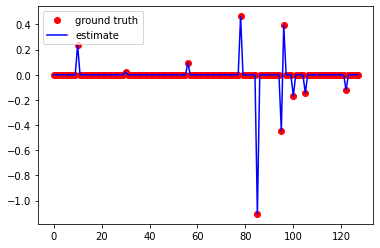

In [10]:
plt.figure()
plt.plot(x0, 'ro', label="ground truth")
plt.plot(np.real(x_pocs), 'b', label="estimate")
plt.legend()


### 1.2 Systematic analysis over a range of measurements
Let's now try a range of different measurements over many trials to see when the linear and the phase-only methods succeed

In [11]:
# sensing model
sensing_model = 'gaussian'

# Dimensions
n = 256
k = 20
m_vec = np.arange(1,256,10)
nb_trials = 100

# Inits
scores_lin = np.zeros((m_vec.size,nb_trials))
scores_po = np.zeros((m_vec.size,nb_trials))

# Main Monte Carlo Loop
pbar = tqdm(total=m_vec.size) #comment this if it doesn't work for you
for m_ind, m in enumerate(m_vec):
    
    # The measurement vector e_1 such that A_z x0 = e_1
    e_1 = generate_canonic_vec(m+2,0)
    
    for s in np.arange(nb_trials):
    
        # Generating the sensing matrix according to the selected model
        A = generate_sensing_mtx(m, n, model = sensing_model)

        # Generating a k-sparse signal, random k-length support, and Gaussian entries
        x = generate_sparse_sig(k,n)

        # Linear measurements
        y = A @ x

        # Phase only measurements
        z = signc(y)

        # Definition of the matrix A_z for sparse signal recovery in PO-CS, such that A_z x0 = (1, 0, ..., 0)  
        A_z = generate_Az(A,z)

        # Let x0 such that ||Ax0||_1 = kappa sqrt(m) (see [1])
        # This is the signal we hope to estimate, as the amplitude of x is lost (see [1])
        x0 = x * kappa * np.sqrt(m) / np.linalg.norm(y,1)
        
        # Linear model (note: running SPGL1 on complex mtx seems wrong). 
        A_equiv = Op2Real(A)
        y_equiv = A_equiv @ x
        x_lin = bpalg(A_equiv, y_equiv)

        # Phase-only model
        x_pocs = bpalg(A_z, e_1)
        
        # Recording SNRs
        scores_lin[m_ind,s] = snr(x_lin,x)
        scores_po[m_ind,s] = snr(x_pocs,x0)
        
    pbar.update(1) #comment this if it doesn't work for you
            
pbar.close() #comment this if it doesn't work for you
        

  0%|          | 0/26 [00:00<?, ?it/s]

Displaying now the success rates, by counting how many times over the number of trials, the reconstruction SNR was above a certain threshold ```success_score``` (e.g., 60 dB) 

m/k: CS 2.05; PO-CS 3.55
PO-CS/CS: 1.7317073170731707
mCS = 41, mPO = 71, 2*mCS - 2 = 80


Text(0, 0.5, 'Recovery Rate')

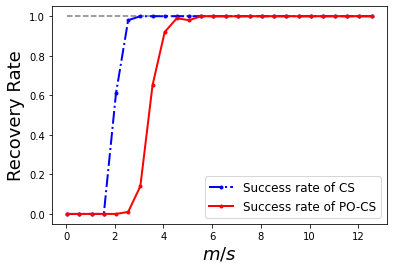

In [12]:
success_score = 60
cslin_success = np.sum(scores_lin>success_score,axis=1)/nb_trials
cspo_success = np.sum(scores_po>success_score,axis=1)/nb_trials

mlin_tr = np.where(cslin_success > 0.5)[0][0]
mpo_tr = np.where(cspo_success > 0.5)[0][0]

print(f"m/k: CS {m_vec[mlin_tr]/k}; PO-CS {m_vec[mpo_tr]/k}")
print(f"PO-CS/CS: {m_vec[mpo_tr]/m_vec[mlin_tr]}")
print(f"mCS = {m_vec[mlin_tr]}, mPO = {m_vec[mpo_tr]}, 2*mCS - 2 = {2*m_vec[mlin_tr]-2}")

plt.figure()
plt.plot(m_vec/k, cspo_success*0 + 1.0, '--', color='gray')
plt.plot(m_vec/k, cslin_success, 'b.-.',linewidth=2, label='Success rate of CS')
plt.plot(m_vec/k, cspo_success, 'r.-',linewidth=2, label='Success rate of PO-CS')

plt.legend(fontsize=12)
#plt.title('Basis Pursuit Recovery Rates')
plt.xlabel('$m/s$',fontsize=18)
#plt.xlim((0,70/k))
plt.ylabel('Recovery Rate',fontsize=18)
#plt.savefig('BP_rec_rate_Gaussian.pdf', bbox_inches='tight', pad_inches=0.025, transparent=True)

## 2. Noisy PO-CS reconstruction

We now consider a noisy PO-CS model described by 

$$
\boldsymbol z = {\rm sign}_{\mathbb C}(\boldsymbol \Phi \boldsymbol x) + \boldsymbol \xi,
\tag{PO-CS}
$$

with $\boldsymbol \xi \in \mathbb C^m$ an additive noise with bounded amplitude, i.e., such that $\|\boldsymbol \xi\|_\infty \leq \tau$.

Note that $\tau < 2$ since there exists a counterexample of additive noise with $\|\boldsymbol \xi\|_\infty \leq 2$ that totally remove any information about the signal in the phase (that is, the random dephasing, see the paper).

In [31]:
# Sensing model
sensing_model = 'gaussian'

# Problem dimensions
n = 100
k = 10
m_vec = np.arange(1,70,3)


# Levels of noise
nb_tau = 16
tau_vec = 2*np.logspace(-3, -1, nb_tau)

# Number of trials
nb_trials = 100

# Inits
scores_po = np.zeros((m_vec.size,nb_tau,nb_trials))

# Main Monte Carlo Loops
pbar = tqdm(total=m_vec.size) #comment this if it doesn't work for you
for m_ind, m in enumerate(m_vec):
    
    # The measurement vector e_1 such that A_z x0 = e_1
    e_1 = generate_canonic_vec(m+2,0)
    
    for s in np.arange(nb_trials):
        
        for t, tau in enumerate(tau_vec):
                        
            # Generating the complex uniform noise with tau variations
            rho = np.sqrt(np.random.uniform(0, 1, m))
            phi = np.random.uniform(0, 2*np.pi, m)
            xi = tau * rho * (np.cos(phi) + np.sin(phi)*1j)
            
            # Generating the sensing matrix according to the selected model
            A = generate_sensing_mtx(m, n, model = sensing_model)

            # Generating a k-sparse signal, random k-length support, and Gaussian entries
            x = generate_sparse_sig(k,n)

            # linear measurements
            y = A @ x
            
            # phase only measurements
            z = signc(y) + xi

            # Let x0 such that ||Ax0||_1 = kappa sqrt(m) (see [1])
            # This is the signal we hope to estimate, as the amplitude of x is lost (see [1])
            x0 = x * kappa * np.sqrt(m) / np.linalg.norm(y,1)

            # Definition of the matrix A_z for sparse signal recovery in PO-CS, such that A_z x0 = (1, 0, ..., 0)  
            A_z = generate_Az(A,z)

            # Defining A_xi to compute varepsilon, the level of noise
            A_xi = generate_Az(A,xi)
            varepsilon = np.linalg.norm(A_xi @ x0)
            
            # Phase-only model
            x_pocs = bpdnalg(A_z, e_1, varepsilon)

            # Recording SNRs
            #scores_lin[m_ind,t,s] = snr(x_lin,x0)
            scores_po[m_ind,t,s] = snr(x_pocs,x0)
            
    pbar.update(1) #comment this if it doesn't work for you
            
pbar.close() #comment this if it doesn't work for you

  0%|          | 0/23 [00:00<?, ?it/s]

Let's plot the result.

<ipython-input-42-bd2bab08cf7d>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['3.0','','','','2.0','','','','1.0'])


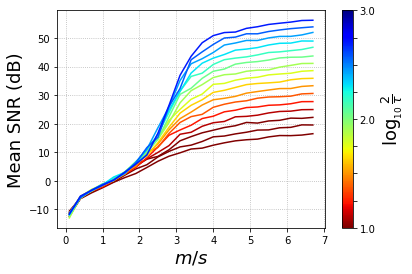

In [42]:
mean_snr = scores_po.mean(axis=2)

fig, ax = plt.subplots(1)

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=np.log10(tau_vec.min()/2), vmax=np.log10(tau_vec.max()/2))
colormap = cm.jet

#colors = plt.cm.magma(np.linspace(0,1,2*nb_tau))

for t in np.flip(np.arange(nb_tau)):
    ax.plot(m_vec/k, mean_snr[:,t], color=colormap(normalize(np.log10(tau_vec[t]))))

# Displaying a grid
ax.grid(linestyle=':')
    
# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(20)
cbar = plt.colorbar(scalarmappaple)
cbar.ax.invert_yaxis() 
cbar.set_label(r'$\log_{_{10}}\, \frac{2}{\tau}$', fontsize=18)
cbar.ax.set_yticklabels(['3.0','','','','2.0','','','','1.0'])
    
#plt.legend(('$\pi$/1000','$\pi$/100','$\pi$/10'))
#plt.title('Basis Pursuit Recovery Rates')
ax.set_xlabel(r'$m/s$', fontsize=18)
ax.set_ylabel('Mean SNR (dB)', fontsize=18)


#fig.colorbar
 
plt.savefig('BPDN_mean_snr.pdf', bbox_inches='tight', pad_inches=0, transparent=True)